<a href="https://colab.research.google.com/github/danielpatrickhug/GitModel/blob/main/random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence-transformers
!pip install datasets


In [39]:
import numpy as np
import random
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
import numba as nb
import math

def normal(x, mu, sigma):
    numerator = np.exp((-(x - mu) ** 2) / (2 * sigma ** 2))
    denominator = sigma * np.sqrt(2 * np.pi)
    return numerator / denominator

def calc_shgo_mode(scores, distribution):
    """
    Calculates the mode of a distribution using the SHGO optimization method.
    :scores: list of distance scores
    :distribution: probability density function estimated from the scores
    :return: mode of the distribution
    """

    def objective(x):
        return -distribution(x)

    bounds = [(min(scores), max(scores))]
    result = scipy.optimize.shgo(objective, bounds)
    return result.x

def estimate_pdf(scores):
    """
    estimate scores probability density function
    :scores: list of distance scores from topic features to topic centroid
    :return: mean and standard deviation of the estimated distribution
    """
    pdf = scipy.stats.gaussian_kde(scores)
    return pdf
@nb.jit(nopython=True)
def boltzmann_acceptance_prob(new_score, current_score):
    if new_score <= current_score:
        return np.exp(new_score - current_score)
    else:
        return 1

@nb.jit(nopython=True)
def custom_acceptance_prob(new_score, current_score, alpha):
    epsilon = 1e-8
    if new_score <= current_score:
        return (new_score + epsilon) / (current_score + epsilon) ** alpha
    else:
        return 1

@nb.jit(nopython=True)
def simple_ratio_acceptance_prob(new_score, current_score):
    epsilon = 1e-8
    if new_score <= current_score:
        return (new_score + epsilon) / (current_score + epsilon)
    else:
        return 1

@nb.jit(nopython=False)
def gaussian_acceptance_prob(new_score, current_score, mu, sigma):
    curr_prob = normal(x=current_score, mu=mu, sigma=sigma)
    move_prob = normal(x=new_score, mu=mu, sigma=sigma)
    acceptance = min(move_prob / curr_prob, 1)
    return acceptance




def metropolis_hastings(graph, num_communities, num_iterations, acceptance_metric='boltzmann', custom_alpha=0.5):
    """
    Implement the Metropolis-Hastings sampling-based community detection.

    Parameters:
    graph (numpy array): The producer-producer similarity graph.
    num_communities (int): The number of communities to be detected.
    num_iterations (int): The number of iterations for the Metropolis-Hastings algorithm.
    acceptance_metric (str): The acceptance probability metric ('boltzmann', 'custom', 'simple_ratio', or 'gaussian_mcmc').
    custom_alpha (float): Custom acceptance probability parameter (only used when acceptance_metric='custom').

    Returns:
    community_labels (list): A list containing the community affiliation for each producer.
    """

    num_producers = graph.shape[0]

    # Initialize the community labels randomly
    community_labels = [random.randint(0, num_communities - 1) for _ in range(num_producers)]

    # Calculate scores for the graph to estimate the Gaussian parameters (mu and sigma)
    scores = [sum(graph[i, j] for j in range(num_producers) if community_labels[j] == community_labels[i]) for i in range(num_producers)]
    if acceptance_metric == "gaussian_mcmc":
        distribution = estimate_pdf(scores)
        mu = calc_shgo_mode(scores, distribution)[0]
        sigma = np.std(scores)

    for _ in range(num_iterations):
        for producer in range(num_producers):
            # Calculate the current community score
            current_community = community_labels[producer]
            current_score = sum(graph[producer, j] for j in range(num_producers) if community_labels[j] == current_community)

            # Choose a new community for the producer
            new_community = random.randint(0, num_communities - 1)

            # Calculate the score for the new community
            new_score = sum(graph[producer, j] for j in range(num_producers) if community_labels[j] == new_community)

            # Calculate the acceptance probability
            if acceptance_metric == 'boltzmann':
                acceptance_prob = boltzmann_acceptance_prob(new_score, current_score)
            elif acceptance_metric == 'custom':
                acceptance_prob = custom_acceptance_prob(new_score, current_score, custom_alpha)
            elif acceptance_metric == 'simple_ratio':
                acceptance_prob = simple_ratio_acceptance_prob(new_score, current_score)
            elif acceptance_metric == 'gaussian_mcmc':
                acceptance_prob = gaussian_acceptance_prob(new_score, current_score, mu, sigma)
            else:
                raise ValueError("Invalid acceptance_metric value. Acceptable values are 'boltzmann', 'custom', 'simple_ratio', or 'gaussian_mcmc'.")

            # Accept or reject the new community
            if random.random() < acceptance_prob:
                community_labels[producer] = new_community

    return community_labels



In [153]:

import numpy as np
import torch
import transformers
import datasets
from sentence_transformers import SentenceTransformer

# Load dataset
dataset = datasets.load_dataset('glue', 'sst2', split='train[:100]')

# Load SentenceTransformer model
model_name = 'bert-base-nli-mean-tokens'
model = SentenceTransformer(model_name)

# Compute sentence embeddings
embeddings = []
strings = []
for example in dataset['sentence']:
    sentence = example
    strings.append(sentence)
    # Encode sentence with the model
    encoding = model.encode(sentence)
    # Append sentence embedding to list
    embeddings.append(encoding)

# Convert list of embeddings to numpy array
embeddings = np.array(embeddings)
num_nodes = len(embeddings)

In [93]:
def linear_kernel_fn(embeddings):
    adjacency_matrix = np.dot(embeddings, embeddings.T)
    return adjacency_matrix


def cos_sim_kernel_fn(a: np.ndarray, b: np.ndarray):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j.
    :return: Matrix with res[i][j]  = cos_sim(a[i], b[j])
    """
    if len(a.shape) == 1:
        a = a.reshape(1, -1)
    if len(b.shape) == 1:
        b = b.reshape(1, -1)
    
    a_norm = np.linalg.norm(a, axis=1, keepdims=True)
    b_norm = np.linalg.norm(b, axis=1, keepdims=True)
    a_normalized = a / a_norm
    b_normalized = b / b_norm
    
    return np.dot(a_normalized, b_normalized.T)

def gaussian_kernel_fn(X, Y, gamma=1.0):
    """
    Computes the Gaussian (RBF) kernel matrix between two sets of vectors X and Y.

    Args:
        X (numpy.ndarray): Input matrix of shape (n_samples1, n_features)
        Y (numpy.ndarray): Input matrix of shape (n_samples2, n_features)
        gamma (float): Kernel bandwidth parameter (default=1.0)

    Returns:
        numpy.ndarray: Kernel matrix of shape (n_samples1, n_samples2)
    """
    dist_matrix = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)
    kernel_matrix = np.exp(-gamma * dist_matrix)
    return kernel_matrix

def degree_matrix(A):
    """
    compute degree matrix using adjacency distance matrix from pairwise distances
    :A: nxn size matrix embedding minmaxed using mu sigma and pairwise distances
    :return: degree matrix
    """
    n = A.shape[0]
    D = np.zeros((n, n))
    for i in range(n):
        D[i, i] = np.sum(A[i, :])
    return D


def graph_laplacian(A):
    """
    compute graph laplacian using degree and adjacency matrix from pairwise distances
    :A: nxn size matrix embedding minmaxed using mu sigma and pairwise distances
    :return: graph laplacian, and degree matrix
    """
    D = degree_matrix(A)
    L = D - A
    return L, D

def degree_centrality(adjacency_matrix):
    degrees = np.sum(adjacency_matrix, axis=0)
    return degrees

def svd_adjacency(adjacency_matrix):
    U, s, V = np.linalg.svd(adjacency_matrix)
    return U, s, V

In [125]:
linear_kernel = linear_kernel_fn(embeddings)
rbf_kernel = gaussian_kernel_fn(embeddings, embeddings, 0.7)
cos_sim_kernel = cos_sim_kernel_fn(embeddings, embeddings)
L, D  = graph_laplacian(linear_kernel)
A_2 = linear_kernel**2
A_3 = linear_kernel**3
normalized_linear_kernel = linear_kernel / np.max(linear_kernel)
A_pi = normalized_linear_kernel ** math.pi

<ipython-input-125-6dc8d9cf8e07>:8: RuntimeWarning: invalid value encountered in power
  A_pi = normalized_linear_kernel ** math.pi


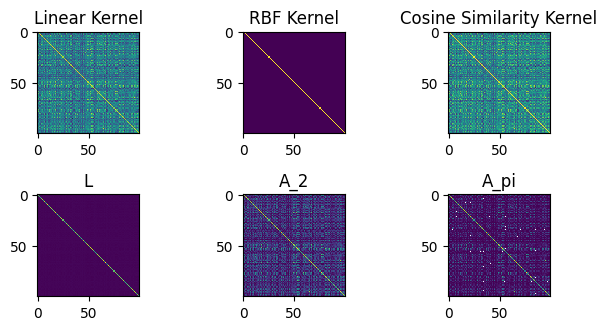

In [95]:
# Set display options for arrays
np.set_printoptions(precision=2, suppress=True)

plt.subplot(3, 3, 1)
plt.imshow(linear_kernel, cmap='viridis', interpolation='nearest')
plt.title('Linear Kernel')

plt.subplot(3, 3, 2)
plt.imshow(rbf_kernel, cmap='viridis', interpolation='nearest')
plt.title('RBF Kernel')

plt.subplot(3, 3, 3)
plt.imshow(cos_sim_kernel, cmap='viridis', interpolation='nearest')
plt.title('Cosine Similarity Kernel')

plt.subplot(3, 3, 4)
plt.imshow(L, cmap='viridis', interpolation='nearest')
plt.title('L')

plt.subplot(3, 3, 5)
plt.imshow(A_2, cmap='viridis', interpolation='nearest')
plt.title('A_2')

plt.subplot(3, 3, 6)
plt.imshow(A_pi, cmap='viridis', interpolation='nearest')
plt.title('A_pi')

plt.tight_layout()
plt.show()

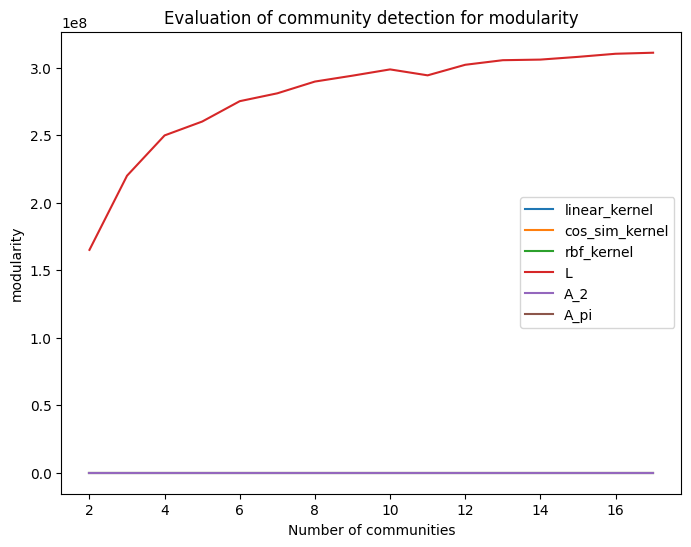

Kernel: linear_kernel, Optimal Number of Communities: 2
Kernel: cos_sim_kernel, Optimal Number of Communities: 17
Kernel: rbf_kernel, Optimal Number of Communities: 17
Kernel: L, Optimal Number of Communities: 17
Kernel: A_2, Optimal Number of Communities: 14
Kernel: A_pi, Optimal Number of Communities: 2


In [123]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_community_labels(community_labels, adjacency_matrix):
    """
    Evaluate the quality of community labels using modularity.

    Args:
    community_labels (list): A list of community labels.
    adjacency_matrix (numpy array): The adjacency matrix of the graph.

    Returns:
    float: The modularity score.
    """
    num_nodes = len(community_labels)
    num_edges = np.sum(adjacency_matrix) / 2
    modularity = 0

    for i in range(num_nodes):
        for j in range(num_nodes):
            if community_labels[i] == community_labels[j]:
                modularity += (adjacency_matrix[i, j] - (np.sum(adjacency_matrix[i, :]) * np.sum(adjacency_matrix[j, :])) / (2 * num_edges)) / (2 * num_edges)

    return modularity

def plot_evaluation_metric(num_communities_range, kernel_metrics, evaluation_metric):
    """
    Plot the evaluation metric as a function of the number of communities for each kernel.

    Args:
    num_communities_range (range): A range of the number of communities.
    kernel_metrics (dict): A dictionary containing the kernel labels as keys and the metric values as values.
    evaluation_metric (str): The evaluation metric used.
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    for kernel, metric_values in kernel_metrics.items():
        ax.plot(num_communities_range, metric_values, label=kernel)

    ax.set_xlabel('Number of communities')
    ax.set_ylabel(evaluation_metric)
    ax.set_title(f'Evaluation of community detection for {evaluation_metric}')
    ax.legend()
    plt.show()

# Define the kernels and kernel labels
kernels = [linear_kernel, cos_sim_kernel, rbf_kernel, L, A_2, A_pi]
kernel_labels = ["linear_kernel", "cos_sim_kernel", "rbf_kernel", "L", "A_2", "A_pi"]

# Evaluate the metric for each kernel and number of communities
num_communities_range = range(2, 18)
kernel_metrics = {
    label: [
        evaluate_community_labels(
            metropolis_hastings(kernel, num_communities=num_communities, num_iterations=100),
            kernel
        )
        for num_communities in num_communities_range
    ]
    for label, kernel in zip(kernel_labels, kernels)
}

# Plot the evaluation metric
plot_evaluation_metric(num_communities_range, kernel_metrics, 'modularity')

# Determine the optimal number of communities for each kernel
optimal_num_communities = {
    kernel: num_communities_range[np.argmax(metric_values)]
    for kernel, metric_values in kernel_metrics.items()
}

# Print the optimal number of communities for each kernel
for kernel, optimal_communities in optimal_num_communities.items():
    print(f'Kernel: {kernel}, Optimal Number of Communities: {optimal_communities}')


In [121]:
from sklearn.metrics import normalized_mutual_info_score

def nmi_similarity(community_labels1, community_labels2):
    """
    Calculate the Normalized Mutual Information (NMI) between two sets of community labels.

    Args:
    community_labels1 (list): The first set of community labels.
    community_labels2 (list): The second set of community labels.

    Returns:
    float: The NMI similarity score.
    """
    return normalized_mutual_info_score(community_labels1, community_labels2)

def nmi_stability_analysis(kernel, num_runs, num_communities, num_iterations=100):
    """
    Perform stability analysis on the kernel-based community detection algorithm using NMI.

    Args:
    kernel (function): The kernel function.
    num_runs (int): The number of times to run the community detection algorithm.
    num_communities (int): The number of communities.
    num_iterations (int): The number of iterations for the Metropolis-Hastings algorithm.

    Returns:
    float: The average NMI similarity score.
    """
    community_label_sets = [
        metropolis_hastings(kernel, num_communities=num_communities, num_iterations=num_iterations)
        for _ in range(num_runs)
    ]

    nmi_similarities = [
        nmi_similarity(community_label_sets[i], community_label_sets[j])
        for i in range(num_runs)
        for j in range(i + 1, num_runs)
    ]

    return np.mean(nmi_similarities)




In [124]:
num_runs = 10

kernel_stability_nmi = {
    label: nmi_stability_analysis(kernel, num_runs, optimal_communities, num_iterations=100)
    for label, kernel, optimal_communities in zip(kernel_labels, kernels, optimal_num_communities.values())
}

# Print the stability results for each kernel using NMI
for kernel, stability in kernel_stability_nmi.items():
    print(f'Kernel: {kernel}, Stability (NMI): {stability}')

Kernel: linear_kernel, Stability (NMI): 1.0
Kernel: cos_sim_kernel, Stability (NMI): 0.6222759711634946
Kernel: rbf_kernel, Stability (NMI): 0.4077139758083179
Kernel: L, Stability (NMI): 0.4040679871615916
Kernel: A_2, Stability (NMI): 0.6226884233672298
Kernel: A_pi, Stability (NMI): 0.1541487429733319


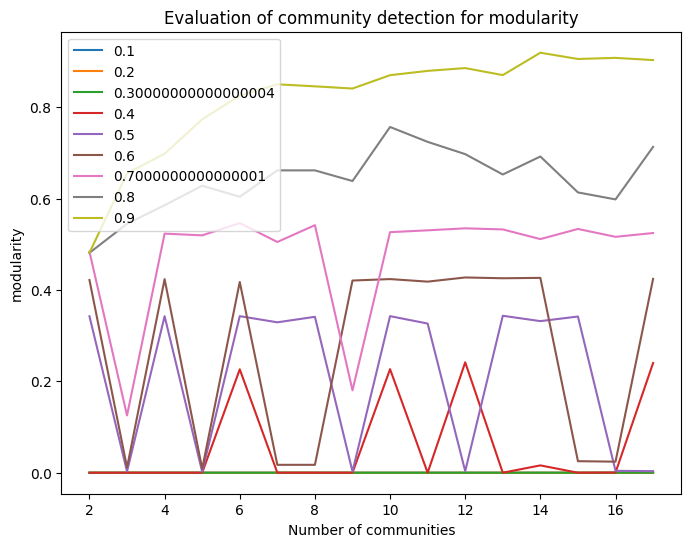

Kernel: 0.1, Optimal Number of Communities: 14
Kernel: 0.2, Optimal Number of Communities: 17
Kernel: 0.30000000000000004, Optimal Number of Communities: 17
Kernel: 0.4, Optimal Number of Communities: 12
Kernel: 0.5, Optimal Number of Communities: 13
Kernel: 0.6, Optimal Number of Communities: 12
Kernel: 0.7000000000000001, Optimal Number of Communities: 6
Kernel: 0.8, Optimal Number of Communities: 10
Kernel: 0.9, Optimal Number of Communities: 14


In [118]:
def compute_kernel(embs, threshold=0.65):
    # Compute the cosine similarity matrix using the provided function
    A = cos_sim_kernel_fn(embs, embs)
    
    # Create an adjacency matrix based on the threshold
    adj_matrix = np.zeros_like(A, dtype=np.float32)
    adj_matrix[A > threshold] = 1
    adj_matrix[A <= threshold] = 0

    return adj_matrix


thresholded_kernels = []
thresh_labels = np.linspace(0.1, 0.9, 9)
for threshold in np.linspace(0.1, 0.9, 9):
    A = compute_kernel(embeddings, threshold)
    thresholded_kernels.append(A)


# Evaluate the metric for each kernel and number of communities
num_communities_range = range(2, 18)
kernel_metrics = {
    label: [
        evaluate_community_labels(
            metropolis_hastings(kernel, num_communities=num_communities, num_iterations=100),
            kernel
        )
        for num_communities in num_communities_range
    ]
    for label, kernel in zip(thresh_labels, thresholded_kernels)
}

# Plot the evaluation metric
plot_evaluation_metric(num_communities_range, kernel_metrics, 'modularity')

# Determine the optimal number of communities for each kernel
optimal_num_communities = {
    kernel: num_communities_range[np.argmax(metric_values)]
    for kernel, metric_values in kernel_metrics.items()
}

# Print the optimal number of communities for each kernel
for kernel, optimal_communities in optimal_num_communities.items():
    print(f'Kernel: {kernel}, Optimal Number of Communities: {optimal_communities}')

In [122]:
num_runs = 10

kernel_stability_nmi = {
    label: nmi_stability_analysis(kernel, num_runs, optimal_communities, num_iterations=100)
    for label, kernel, optimal_communities in zip(thresh_labels, thresholded_kernels, optimal_num_communities.values())
}

# Print the stability results for each kernel using NMI
for kernel, stability in kernel_stability_nmi.items():
    print(f'Kernel: {kernel}, Stability (NMI): {stability}')

Kernel: 0.1, Stability (NMI): 0.6222623051790469
Kernel: 0.2, Stability (NMI): 0.8
Kernel: 0.30000000000000004, Stability (NMI): 0.33357383107428173
Kernel: 0.4, Stability (NMI): 0.3402375479931964
Kernel: 0.5, Stability (NMI): 0.46042171902513424
Kernel: 0.6, Stability (NMI): 0.6053448243765719
Kernel: 0.7000000000000001, Stability (NMI): 0.3146463639788492
Kernel: 0.8, Stability (NMI): 0.24320928256064475
Kernel: 0.9, Stability (NMI): 0.32631929882252053


In [185]:
# Wired: use an SVM
from sklearn import svm

community_labels = metropolis_hastings(linear_kernel, num_communities=14, num_iterations=1000, acceptance_metric="custom"),
print(len(community_labels[0]))


100


In [157]:
len(strings)

100

In [161]:
len(community_labels[0])

100

In [177]:
print(community_labels[0])

[0, 2, 2, 1, 3, 3, 3, 1, 0, 3, 0, 1, 3, 2, 1, 0, 1, 2, 0, 2, 1, 1, 2, 3, 3, 0, 0, 3, 1, 1, 3, 0, 0, 1, 2, 0, 2, 2, 1, 0, 2, 3, 3, 3, 2, 1, 0, 0, 1, 3, 0, 2, 2, 2, 2, 0, 1, 0, 1, 1, 2, 3, 1, 1, 3, 2, 3, 3, 2, 0, 3, 0, 0, 2, 0, 3, 0, 1, 3, 2, 3, 1, 2, 3, 1, 0, 3, 1, 2, 3, 1, 0, 3, 3, 0, 0, 1, 1, 2, 3]


In [186]:
from collections import defaultdict

def group_strings_by_index(strings, community_labels):
    groups = defaultdict(list)
    for i, s in enumerate(strings):
        groups[community_labels[i]].append(s)
    return groups

grouping = group_strings_by_index(strings, community_labels[0])

In [187]:
grouping

defaultdict(list,
            {8: ['hide new secretions from the parental units ',
              "for those moviegoers who complain that ` they do n't make movies like they used to anymore ",
              "the part where nothing 's happening , ",
              'the entire point of a shaggy dog story , of course , is that it goes nowhere , and this is classic nowheresville in every sense . ',
              'a muddle splashed with bloody beauty as vivid as any scorsese has ever given us . ',
              'a doa ',
              'though ford and neeson capably hold our interest , but its just not a thrilling movie ',
              'of the most highly-praised disappointments i ',
              ", like life , is n't much fun without the highs and lows ",
              'strung-together moments '],
             10: ['contains no wit , only labored gags ',
              "that 's far too tragic to merit such superficial treatment ",
              'lend some dignity to a dumb story ',
        

In [143]:
print(embeddings.shape)

(100, 768)


In [188]:
# Wired: use an SVM
from sklearn import svm

# train our (Exemplar) SVM
# docs: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
clf = svm.LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-6, C=0.1)
clf.fit(embeddings, community_labels[0]) # train



  

LinearSVC(C=0.1, class_weight='balanced', max_iter=10000, tol=1e-06,
          verbose=False)

In [191]:
clf.coef_

array([[ 0.07,  0.02, -0.07, ...,  0.09,  0.01, -0.01],
       [ 0.01, -0.03,  0.02, ..., -0.05, -0.03, -0.01],
       [-0.04, -0.01,  0.02, ..., -0.01, -0.  , -0.03],
       ...,
       [-0.05,  0.03,  0.01, ...,  0.01,  0.07,  0.04],
       [-0.03, -0.02, -0.01, ..., -0.03,  0.  ,  0.01],
       [ 0.02,  0.  , -0.01, ...,  0.02, -0.03, -0.03]])

In [192]:
from sklearn.kernel_ridge import KernelRidge

# train our Kernel Ridge Regression
# docs: https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
krr_clf = KernelRidge(alpha=1.0, kernel='rbf')
krr_clf.fit(embeddings, community_labels[0]) # train

KernelRidge(alpha=1.0, kernel='rbf')

In [194]:
krr_clf.dual_coef_

array([ 2.57,  2.68,  5.43, -4.43,  2.09,  2.4 , -2.63,  2.34,  1.4 ,
       -2.88,  5.55,  1.78,  0.75, -1.18,  3.42,  5.05,  5.25, -2.84,
       -1.81,  1.81,  2.71,  4.51,  4.25, -5.25,  2.99,  3.61,  3.41,
       -3.52, -3.28,  4.46, -0.46, -4.88, -2.08,  2.19, -3.13, -2.8 ,
        0.33,  0.62,  5.33, -0.6 ,  1.03, -1.33,  3.11,  2.86,  4.99,
        3.37, -0.22,  1.02,  3.02,  4.92, -5.47,  2.09, -6.28,  3.98,
       -2.41,  2.53, -0.53, -3.2 , -4.3 , -2.16, -4.6 , -5.12, -4.24,
       -3.97,  1.4 , -3.76,  3.85, -1.33, -4.61,  5.88,  1.32, -5.09,
       -3.23, -0.32, -4.63, -3.97,  2.72,  2.32,  1.61,  3.05, -3.6 ,
        3.54,  0.95, -0.19,  1.07, -1.77, -3.93, -4.67,  0.33,  0.14,
       -6.2 ,  0.2 ,  2.04, -5.42,  0.06,  3.36,  2.79,  1.18, -2.41,
        3.54])

In [196]:
test_strings = [
    "This movie was a waste of time. I can't believe I sat through it.",
    "I loved the characters in this movie. They were so well-developed.",
    "The plot of this movie was nothing but clichés.",
    "This film had me smiling from beginning to end.",
    "I found this movie to be preachy and poorly acted.",
    "This movie was a beautiful tribute to the subject matter.",
    "The digital video used in this film was quite ugly.",
    "This movie had me laughing out loud.",
    "I couldn't find anything of interest in this film.",
    "This movie was so bad, I walked out of the theater.",
    ]*10
test_embeddings= model.encode(test_strings)

In [189]:
# infer on whatever data you wish, e.g. the original data
similarities = clf.decision_function(test_embeddings)
sorted_ix = np.argsort(-similarities)
print("top 10 results:")
for i, pred in enumerate(sorted_ix[:10]):
    print(test_strings[i])
    print(f"row {pred}")
    for c in pred[:1]:
        print(grouping[c])
    
    print()

top 10 results:
This movie was a waste of time. I can't believe I sat through it.
row [6 2 8 0 5 7 3 1 4]
["it 's about issues most adults have to face in marriage and i think that 's what i liked about it -- the real issues tucked between the silly and crude storyline ", 'heroes ', "poor ben bratt could n't find stardom if mapquest emailed him point-to-point driving directions . ", 'well-rounded tribute ', 'fashioning an engrossing entertainment out ', 'alternating between facetious comic parody and pulp melodrama , this smart-aleck movie ... tosses around some intriguing questions about the difference between human and android life ', "it does n't follow the stale , standard , connect-the-dots storyline which has become commonplace in movies that explore the seamy underbelly of the criminal world ", "it 's robert duvall ! "]

I loved the characters in this movie. They were so well-developed.
row [2 8 0 6 4 3 5 1 7]
['demonstrates that the director of such hollywood blockbusters as pa

In [106]:
import numpy as np

def l1_regularization(adj_matrix, alpha=1.0):
    """
    Compute the L1 regularization term for the given adjacency matrix.
    
    Args:
    adj_matrix (numpy array): The adjacency matrix.
    alpha (float): The regularization coefficient, default is 1.0.
    
    Returns:
    float: The L1 regularization term.
    """
    return alpha * np.sum(np.abs(adj_matrix))

def l2_regularization(adj_matrix, alpha=1.0):
    """
    Compute the L2 regularization term for the given adjacency matrix.
    
    Args:
    adj_matrix (numpy array): The adjacency matrix.
    alpha (float): The regularization coefficient, default is 1.0.
    
    Returns:
    float: The L2 regularization term.
    """
    return alpha * np.sum(np.square(adj_matrix))

def hinge_loss(y_true, y_pred):
    """
    Compute the hinge loss for the given true labels and predictions.

    Args:
    y_true (numpy array): The true labels.
    y_pred (numpy array): The predicted labels.

    Returns:
    float: The hinge loss.
    """
    return np.mean(np.maximum(0, 1 - y_true * y_pred))


In [132]:
alpha_labels = np.linspace(0.1, 0.9, 9)
for alpha in np.linspace(0.1, 0.9, 9):
    r = l1_regularization(embeddings, alpha)
    print(r)
print()   
alpha_labels = np.linspace(0.1, 0.9, 9)
for alpha in np.linspace(0.1, 0.9, 9):
    r = l2_regularization(embeddings, alpha)
    print(r)

3603.7781250000003
7207.556250000001
10811.334375000002
14415.112500000001
18018.890625
21622.66875
25226.446875
28830.225000000002
32434.003125

2737.0857421875003
5474.171484375001
8211.2572265625
10948.342968750001
13685.4287109375
16422.514453125
19159.6001953125
21896.685937500002
24633.7716796875


In [203]:

import numpy as np

class KernelRidgeRegression:
    def __init__(self, kernel, alpha):
        self.kernel = kernel
        self.alpha = alpha
        
    def fit(self, X, y):
        K = self.kernel(X, X)
        self.coef_ = np.dot(np.linalg.inv(K + self.alpha*np.eye(len(X))), y)
        self.X_train_ = X
    
    def predict(self, X):
        K_test = self.kernel(X, self.X_train_)
        return np.dot(K_test, self.coef_)


# define the kernel function
def rbf_kernel(X1, X2, gamma=0.1):
    dist_sq = np.sum(X1**2, axis=1)[:, np.newaxis] + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * dist_sq)

# instantiate the model and fit the data
model = KernelRidgeRegression(kernel=rbf_kernel, alpha=0.1)
model.fit(embeddings, community_labels[0])

y_pred = model.predict(test_embeddings)

y_pred


array([0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.  ])

In [204]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

def test_equivalence(n_samples=100, n_features=10, n_components=5, alpha=0.1, gamma=0.1, random_state=0):
    rng = np.random.RandomState(random_state)

    # Generate random data
    X = rng.randn(n_samples, n_features)
    y = rng.randn(n_samples)

    # Fit KRR
    krr = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
    krr.fit(X, y)

    # Fit Ridge with truncated SVD
    ridge = make_pipeline(TruncatedSVD(n_components=n_components), Ridge(alpha=alpha))
    ridge.fit(X, y)

    # Generate test data
    X_test = rng.randn(n_samples, n_features)

    # Calculate MSE for KRR
    y_pred_krr = krr.predict(X_test)
    mse_krr = np.mean((y_pred_krr - y)**2)

    # Calculate MSE for Ridge with truncated SVD
    y_pred_ridge = ridge.predict(X_test)
    mse_ridge = np.mean((y_pred_ridge - y)**2)

    # Print results
    print(f"KRR MSE: {mse_krr}")
    print(f"Ridge with truncated SVD MSE: {mse_ridge}")
test_equivalence()

KRR MSE: 1.4995167498159296
Ridge with truncated SVD MSE: 1.0238716151036023
